# Contrail Detection - Part I - UNet
This is part 1 in a short series of notebooks that will aim to tackle the Kaggle competition of predicting the presence of contrails in infrared image bands. For other posts on this topic, please visit the original data science project page.

## Outline

- Introduce the competition
- Introduce the data used
- Show what the data actually looks, including its structure, and corresponding false color images.
- Introduce the type of problem this is
- Link to the most basic of implementations of UNet (and summarize if need be)
- Adapt UNet to this problem, along with describing the backbone that is used.
- Show PyTorch Lightning in action.
- Finally train the model.
- Show performance on both training and validation images (and properly describe the Dice coefficient metric)


## Introduction
It's a clear blue sky, and you look up at and see a plane flying overhead. Not only that, but you see a thin line following it. This is a **contrail**. Although it might seem they dissipate and disappear from the naked eye soon after, these actually linger in the atmosphere for far longer. Contrails occur when small exhaust particles from the aircraft's engine come into contact to the cold air in the atmosphere. Ice crystals from around these many particles, until they become large enough to see with the naked eye. How long these contrails are visible depends on the temperature and humidity of the air. Some of these last long enough that they appear to be clouds on their own.

### Why detection?
Unfortunately, although they look innocuous, these contrail emissions measurably contribute to climate change. During nighttime, the Earth naturally radiates heat as it cools down. **However, the many contrails that are present in the atmosphere can mitigate and prevent this effect, eventually trapping heat and causing unnatural warming**. It has been shown that using biofuels can reduce contrail formation by a large amount. In order to produce more solid research and confirm the extent of which these contrails are contributing to global warming, scientists need a quick and reliable way of detecting them in the atmosphere. These include contrails that are not visible to the naked eye anymore.

### Kaggle competition details
Kaggle has a competition surrounding this topic. Participants are given square images of the atmosphere that may or may not contain contrails, and are asked to produce classify **by the pixel** whether said pixel contains part of a contrail. Most notably, each sample consists a time-series of images, in various **infrared** bands. This means that normally these contrails will not be visible to the naked eye. The time-series of images are provided because these are the images that are given to the original human classifiers. Due to their structure, contrails look and move differently than regular clouds.

## Import Packages
We will go over the actual data and model we will use in a bit, but first, we need to import everything we will need. The core libraries we will use are PyTorch 2.2 and PyTorch Lightning. The latter will streamline the training and fitting process (similar to TensorFlow's `.fit()` method). PyTorch has been built on a CUDA 12.1 system. Other CUDA versions might force a downgrade to PyTorch's versions, but the core functionalities should remain the same.

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.hub import load_state_dict_from_url
import torchinfo

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

from torchmetrics import Dice, MeanMetric
from torchmetrics.classification import BinaryAccuracy

import pytorch_lightning as pl

ROOT = '../'
DATA_DIR = os.path.join(ROOT, 'data', 'google-research-identify-contrails-reduce-global-warming', 'validation')

## Data Overview
As mentioned before, the data consists of many sets of time-series images. Each set comprises of the same 256 by 256 patch of the sky over a time period. We have one central *target* time point (the ground truth contrail locations are given with respect to this time step), 4 time steps before, and 3 time steps after, for a total of 8 total time steps. Instead of visual RGB images, 8 separate bands in the IR range are given. Along with that, a single matrix of `human_pixel_masks.npy` corresponds to the ground truth contrails for the middle time point. Each pixel is either a 0 or 1, corresponding to "no contrail" or "contrail".

The training data consists of more than 20 thousand samples, while validation has just under 2 thousand. Due to the sheer size of the training set, **we will only work off of the validation set, which is around 33 GB in size.**

To download just the validation, first ensure you have at least 60 GB of free space. Then, head to the [competition data download page](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data?select=validation) (accept the competition rules if necessary) and download the zip folder `validation.zip`. Then, unzip the contents to `/data/google-research-identify-contrails-reduce-global-warming/validation` and you should be all set. Delete the zip file after extraction if you want to free up some space.

### About the IR bands
Infrared is a band of light that is of longer wavelength than the visible spectrum. Infrared is very sensitive to heat, and so this is why you see infrared being used in thermal imaging cameras. When projecting IR into the atmosphere, different exposure levels will be generated. Each "band" of infrared exposes the atmosphere to particular wavelength, and individual images are generated in this way. Information on what each band's wavelength is and what each is used for can be found [here](https://www.goes-r.gov/mission/ABI-bands-quick-info.html). Our data consists of **bands 8 through 16** for each sample. For example, band 8 is used for identifying jet streams, while band 16 is used for carbon dioxide detection e.g. volcanic ash. During analysis and processing, these bands can be analyzed directly, but it is difficult to interpret these values for the layman. For this reason, when showing images of note, we will be using **false color images**. 

False color images are images where the colors are artificially calculated from non-visible light images. While the images will be in color, these do not represent the actual color in real life. Using specific band values, along with minor transformations, different kinds of color images can be produced. Because we need to visualize contrails, which are similar to cirrus clouds, we will use the **ash** color scheme (on page 7 in [this document](https://eumetrain.org/sites/default/files/2020-05/RGB_recipes.pdf). For this, we need images taken with $8.7\mu m$, $10.8\mu m$, and $12\mu m$. These correspond closest to bands 11, 14, and 15. According to the document, the following will be our RGB values:

$$
\begin{aligned}
    R &= b_{15} - b_{14} \\
    G &= b_{14} - b_{13} \\
    B &= b_{14}
\end{aligned}
$$

In addition, the "Range" columns signify how to rescale the ensuing values given the minimum and maximum. For example, for the red and green channels, the minimum and maximum should be assumed to be $-4$ and $2$ and rescaled accordingly.

### False Color Example + Contrail Mask
Using the rules, we can easily convert a sample image into a false color image. This will help us more easily visualize the contrails, and their masks.

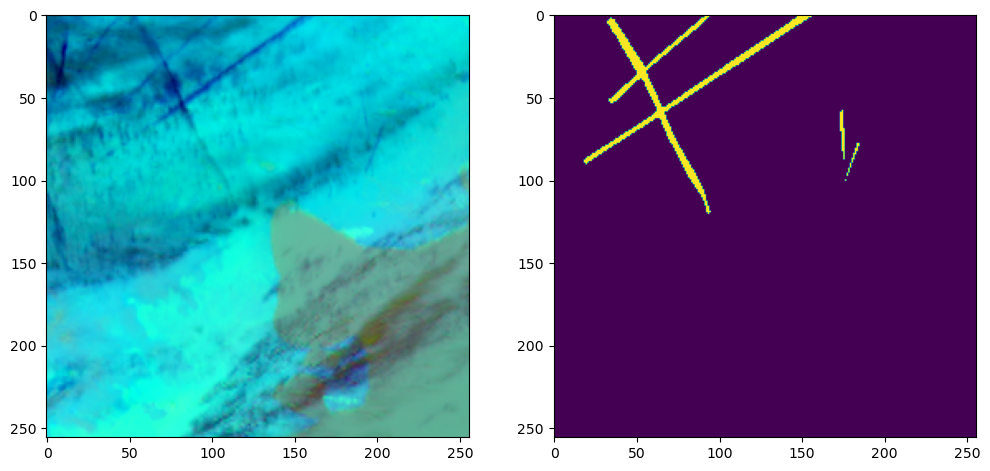

In [26]:
sample_id = '82272245413161715'
# Read the 3 bands we need, and extract the target time step
band_11 = np.load(os.path.join(DATA_DIR, sample_id, 'band_11.npy'))[:, :, 5]
band_14 = np.load(os.path.join(DATA_DIR, sample_id, 'band_14.npy'))[:, :, 5]
band_15 = np.load(os.path.join(DATA_DIR, sample_id, 'band_15.npy'))[:, :, 5]

# Let's save the image size, will be useful later
IMAGE_SIZE = band_11.shape[0]

# Calculate R, G, and B channels, with the scaling.
# Clip to between 0 and 1 so that we don't get invalid values
red = ((band_15 - band_14 + 4) / (2 + 4)).clip(0, 1)
green = ((band_14 - band_11 + 4) / (5 + 4)).clip(0, 1)
blue = ((band_11 - 243) / (303 - 243)).clip(0, 1)
# Stack them correctly, and transpose so that the channels are list
image = np.stack((red, green, blue), axis=0).transpose((1, 2, 0))

# Now read the mask, it has an extra singleton channel dimension at the end,
# so get rid of that.
mask = np.load(os.path.join(DATA_DIR, sample_id, 'human_pixel_masks.npy')).squeeze()

# Plot it using imshow!
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
ax.imshow(image)
ax = plt.subplot(1, 2, 2)
ax.imshow(mask)

With the false color image and the mask side-by-side, the exact location of the contrail can be clearly seen. Notice other "wispy" features in the color image which aren't classified as contrails. These are most likely cirrus clouds or other features. It's this combination that generally makes it a bit tough for scientists to pick these out by hand, and why a time series of images are valuable.

Even later, this code block will serve as our "preprocessing" of the data. Each sample will be converted to a false color image before being fed through our network.

### Data characteristics
Even though the preprocessing seems relatively minor, we still should examine the data for general properties. For example, how many images actually contain contrails?

In [35]:
# First some basic counts...
samples = next(os.walk(DATA_DIR))[1]
num_samples = len(samples)
print(f'There are {num_samples} different images.')

# Next, we'll count how many images have contrails at all,
# and also, what percentage of pixels are contrails, and what aren't.
no_contrail_images = 0
total_con_pixels = 0
for sample in samples:
    mask = np.load(os.path.join(DATA_DIR, sample, 'human_pixel_masks.npy')).squeeze()
    # Since they're all 0 and 1, summing will tell us how many contrail pixels there are.
    contrail_pixels = np.sum(mask)
    if contrail_pixels == 0:
        no_contrail_images += 1
    total_con_pixels += contrail_pixels

print(f'There are {no_contrail_images} images ({no_contrail_images / num_samples * 100:2.2f}%) without ANY contrails.')
print(f'There are {total_con_pixels} ({total_con_pixels / (num_samples * IMAGE_SIZE * IMAGE_SIZE) * 100:2.2f}%) pixels that are contrails.')

There are 1856 different images.
There are 1304 images (70.26%) without ANY contrails.
There are 220446 (0.18%) pixels that are contrails.


These are interesting metrics. When all is said and done, **only about 30%** of the images contain any contrails at all. Even more extreme, more than **99.8%** of pixels don't have contrails. These numbers are important, because these will influence how we treat eventual model performance metrics. Using pure accuracy, the model will be very heavily skewed towards predicting no contrails anywhere. Doing so will lead to near-perfect accuracy. 

This tells us that accuracy is in fact a very poor metric to evaluate model performance. Expectedly, Kaggle themselves do not use this as performance indicators. Instead, they use the **Dice coefficient**.

#### Dice coefficient
In general, the [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) is a measure of similarity between two sets. In our case, the "sets" is the set of predictions and the set of ground truth masks. Since we have boolean data, we can write in the form of true positives, false positives, and false negatives:

$$
D = \frac{2TP}{2TP + FP + FN}
$$

With our earlier example, if a model does not predict a contrail anywhere, then we have 0 true positives, and thus the Dice coefficient evaluates to **zero**. This is much more indicative of the model performance in this case, rather than the 99.8% accuracy. If we were to instead predict contrails everywhere, then we the metric would be:

$$
D = \frac{2TP}{2TP + FP + FN} = \frac{2(220\,446)}{2(220\,446) + \big(1856(256)^2 - 220\,446\big) + 0} = \boxed{0.0036}
$$

which is also indicative of poor performance. Therefore, the Dice coefficient is vastly superior to the traditional accuracy in this case. Even more, although we do have classification, the network we build will have to predict each pixel individually, rather than the image as a whole.


## Building the network
Speaking of the network, this isn't quite the usual image classification model that is widely used everywhere. Instead, this is **image segmentation**. The main reason is that the solution to this problem differs from the conventional classification:

- _Image classification_ - Given a single image, classify the **entire** image to a class.
- _Image segmentation_ - Given a single image, classify **each pixel** to a class.

What are some applications of image segmentation? They are widely used in the medical imaging field, such as detecting cancerous regions in tissue. They can also be used in pedestrian and brake light detection for autonomous vehicle systems. In the end, it is still an important enough subfield that much research has gone into this topic.

For our use case, we will extract the _target_ time step, and we will be predicting each pixel as either containing a contrail, or not. At the core, this is classic binary classification, just performed at the pixel level instead of the image level.

One important consequence of predicting each pixel is that **the size of both the input and output will be the same.** In practice, if our input image size is 256 by 256 pixels, then our output will also be 256 x 256 pixels. We classify all the pixels all at once given a single image.

### UNet
The different classification task that this problem requires means a different model architecture. Usually, the likes of ResNet and EfficientNet can be used as pre-trained image classification networks. But instead, we'll use a type of network called a **UNet**.

A UNet is specifically designed for image segmentation. The UNet is split into two parts: the encoder and the decoder. The encoder has the original image as input, and continually downscales the image to smaller and smaller sizes, not unlike a traditional classification. However, instead of a classification layer, the decoder is attached instead. The decoder retrieves the encoder output, and contiually **upsamples** each layer, until the final output which will be the same size as the input image. Crucially, **the values of intermediate encoding output are used as input to each layer in the decoder.** This is the core reason why UNets are very powerful. This structure also leads to the network graph being in the shape of a "U", hence UNet. The image below is extracted from the [original UNet paper](https://arxiv.org/pdf/1505.04597.pdf).

![unet](unet.png)

Commonly, the encoder of the UNet is generally a pre-trained image classification network, such as ResNet or MobileNet.

### Converting TensorFlow to PyTorch
TensorFlow has a [great tutorial](https://www.tensorflow.org/tutorials/images/segmentation) on image segmentation and how to build the UNet, using MobileNet as a backend encoder. However, we are in PyTorch, so we have some work to do converting it. We can simply download the MobileNet model from `torch.hub`, but other than that, we have to two key parts we need to implement:

1. **pix2pix block** - This is the layer block that is responsible for upsampling and increasing the resolution of the image. It is a core part of the decoder than is absolutely necessary.
2. **Intermediate connections of MobileNet to the decoder** - We also need to extract the correct layers from MobileNet, and establish connections from that to the corresponding layers in the decoder. These are the gray arrows in the UNet picture above.


#### Pix2pix
This is the simpler of the two. TensorFlow's version of the pix2pix upsample method is defined [here](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) as part of the `upsample()` method. At its core, pix2pix is just 4 layers put together: a transposed 2D convolution, batch normalization, dropout, and ReLU activation. It is fairly straightforward to define these in this order. This version perfectly scales up the image by a factor of 2. Since our image size is a power of 2 (256), this works out nicely. All we need are the input and output channels, and the size of the kernel. Like the original, we should also initialize the weights of the transpose layer with a mean of 0 and standard deviation of 0.02.

In [36]:
class Pix2PixUpsample(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size):
        super().__init__()
        
        self.conv2d = nn.ConvTranspose2d(in_chan, out_chan, kernel_size, stride=2, padding=1, bias=False)
        # Initialize weights with mean 0 and standard deviation 0.02
        nn.init.normal_(self.conv2d.weight, mean=0, std=0.02)
        
        self.model = nn.Sequential(
            self.conv2d, 
            nn.BatchNorm2d(out_chan),
            nn.Dropout(0.5),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.model(x)
        

Passing a random tensor through, you can see the layer block in action. It perfectly scales up the input by a factor of 2, given a kernel size of 4.

In [39]:
x = torch.rand((4, 30, 64, 64))
print('Shape before:', x.shape)
pix2pix = Pix2PixUpsample(30, 60, kernel_size=4)
print('Shape after:', pix2pix(x).shape)

Shape before: torch.Size([4, 30, 64, 64])
Shape after: torch.Size([4, 60, 128, 128])


#### Extracting Intermediate MobileNet Features
This is trickier, because there are strict requirements in which features we extract. Extracting the wrong features will lead to shape mismatches when we concatenate them during decoder output. According to TensorFlow, the following are the layer names and their corresponding sizes.

```python
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
```
We'll need to examine PyTorch's MobileNet to see which layers we need. However, by default, PyTorch does not show what the output shapes are for each layer. For that, we use the `torchinfo` package. TensorFlow's input was actually half the size of our input (128 by 128), and the corresponding chosen layers reduced the image by a factor 2, 4, and so on. So in our case, we need to search for layers whose output shapes are 128 x 128, 64 x 64, etc.

Finally, once we find the first one, it is simple to find the rest, because of the indexing present in the numbering.

In [44]:
mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
batch_size = 8
torchinfo.summary(mobilenet, input_size=(batch_size, 3, 256, 256), depth=4)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [8, 1000]                 --
├─Sequential: 1-1                                  [8, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                   [8, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                            [8, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                       [8, 32, 128, 128]         64
│    │    └─ReLU6: 3-3                             [8, 32, 128, 128]         --
│    └─InvertedResidual: 2-2                       [8, 16, 128, 128]         --
│    │    └─Sequential: 3-4                        [8, 16, 128, 128]         --
│    │    │    └─Conv2dNormActivation: 4-1         [8, 32, 128, 128]         352
│    │    │    └─Conv2d: 4-2                       [8, 16, 128, 128]         512
│    │    │    └─BatchNorm2d: 4-3                  [8, 16, 128, 128]         32
│    └─InvertedResidual: 2-3    

There are many layers with an output of 128 x 128. Which one do we choose? A quick look at the **second line** of the UNet output graph on TensorFlow's tutorial page, we see that we need the output with **96 channels** i.e. 96 x 128 x 128. Therefore, it is the `Conv2dNormActivation` of the second `InvertedResidual` block. As for the actual layer name, we have to peek into the `mobilenet` object.

In [46]:
mobilenet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

The layer names are in the parentheses preceding each line. The full layer name comprises a concatenation of the individual names separated by periods e.g. for the first extraction layer, we have `features.2.conv.0`. Using the original indices, we can get the other names as well:

- `features.4.conv.0`
- `features.7.conv.0`
- `features.14.conv.0`

For the final block, since we want the full projection, we have 2 at the end instead of 0: `features.17.conv.0`. Now that we have all the corresponding layer names, we can use the `create_feature_extractor` method to extract the values in these layers.

In [47]:
layers = {
    'features.2.conv.0': 'block_1',
    'features.4.conv.0': 'block_3',
    'features.7.conv.0': 'block_6',
    'features.14.conv.0': 'block_13',
    'features.17.conv.2': 'block_16'
}
encoder = create_feature_extractor(mobilenet, return_nodes=layers)

## Creating the Dataset
Use PyTorch Lightning to create the LightningDataModule, using the RGB extraction that we went over from before. 

## Building the Model
Go over the eventual structure of the model itself, from the MobileNet backend, to extracting the individual layers of MobileNet, to the upsampling using pix2pix, until the final image output of the same size as the original. Along the way, describe how PyTorch Lightning is being used and integrated into the pipeline.

## Fitting the Model
Actually fit the model, by creating the Trainer objects and calling `.fit()`. Your choice on if you want callbacks here. One important callback could be the plotting of the training and validation images along the way, and showing them afterwards.

## Results
Show actual metrics, most notably the Dice coefficient, in addition to the general accuracy. ALso show how the training and validation images improve over time. Go over the eye test, to see how well it's actually doing, and talk about drawbacks about using a bare UNet. A bare UNet doesn't perform very well with "straight-line" segments. The best possible results are usually these fuzzy lines, instead of ones with hard edges. 

## Ways to Improve
A good first start to this problem, but additional optimizations can be made. Refer to the initial metric that many images do not contain contrails at all. Propose a two-step model, which first predicts presence of any contrails at all, a binary classification at the image level, and then applies segmentation if the binary model believes there are contrails present in the image. This should be part 2.